In [33]:
pip install yfinance 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
import numpy as np
import seaborn as sns
import datetime as dt
import pandas as pd
import yfinance as yf
from pandas.plotting import scatter_matrix
import pandas_datareader.data as web
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

from pickle import dump
from pickle import load

In [35]:
 # n is number of spots
def createDataset(n):
  x = np.linspace(0,10,n)
  y = np.sin(x)+np.random.randn(n)*0.2
  return x,y

In [36]:
X,Y = createDataset(100)

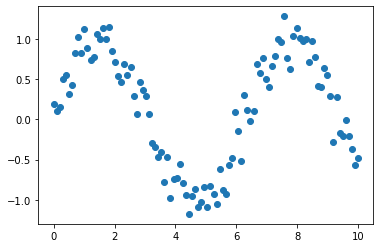

In [37]:
plt.scatter(X,Y)

# EXPLOTORY DATA ANALYSIS EDA

In [38]:
start = dt.datetime(2018,1,1)
end = dt.datetime(2023,3,13)

stkTicker = ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOG']
ccyTicker = ['DEXJPUS','DEXUSUK']
idxTicker = ['SP500', 'DJIA', 'VIXCLS']

yf.pdr_override()
stkData = yf.download(stkTicker, start, end)
ccyData = web.get_data_fred(ccyTicker, start, end)
idxData = web.get_data_fred(idxTicker, start, end)

[*********************100%***********************]  5 of 5 completed


In [39]:
XMerged = stkData['Adj Close'].merge(ccyData, how='inner', left_index=True, right_index=True)
XData = XMerged.merge(idxData, how='inner', left_index=True, right_index=True)
XData.head()

,AAPL,AMZN,GOOG,MSFT,TSLA,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS
2018-01-02,40.888062,59.450500,53.250000,80.738159,21.368668,112.18,1.3596,2695.81,24824.01,9.77
2018-01-03,40.880939,60.209999,54.124001,81.113907,21.150000,112.28,1.3522,2713.06,24922.68,9.15
2018-01-04,41.070839,60.479500,54.320000,81.827827,20.974667,112.78,1.3539,2723.99,25075.13,9.22
2018-01-05,41.538437,61.457001,55.111500,82.842354,21.105333,113.18,1.3562,2743.15,25295.87,9.22
2018-01-08,41.384163,62.343498,55.347000,82.926888,22.427334,113.08,1.3566,2747.71,25283.00,9.52


In [40]:
XData.describe()

,AAPL,AMZN,GOOG,MSFT,TSLA,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS
count,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000,1289.000000,1289.000000,1306.000000,1306.000000,1306.000000
mean,98.378953,118.956150,86.291304,191.776775,133.153346,114.203002,1.298476,3469.925092,29213.972825,21.277496
std,46.637166,35.240797,30.738538,74.823108,116.094410,10.849967,0.069075,665.248626,4049.187445,8.307352
min,34.257286,59.450500,48.811001,79.855156,11.931333,102.520000,1.070300,2237.400000,18591.930000,9.150000
25%,49.765365,89.128374,58.654626,118.384384,21.259500,107.840000,1.249800,2853.905000,25743.387500,15.785000
50%,106.846169,103.665001,75.436749,200.953949,103.021999,109.960000,1.303400,3332.765000,28243.860000,19.810000
75%,143.375389,157.478127,112.364876,253.696167,233.882496,113.870000,1.353900,4062.387500,33291.355000,24.867500
max,180.683868,186.570496,150.709000,339.075531,409.970001,149.820000,1.433200,4796.560000,36799.650000,82.690000


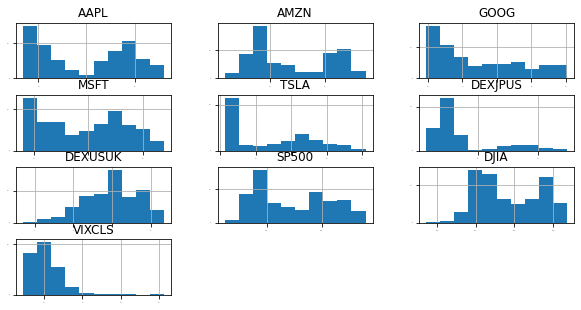

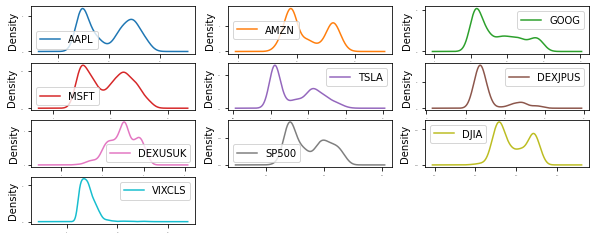

In [41]:
XData.hist(sharex=False, sharey=False, layout=(4,3), xlabelsize=1, ylabelsize=1, figsize=(10,5))
plt.title('Histogram')
plt.show()

XData.plot(kind='density', subplots=True, layout=(4,3), sharex=False, legend=True, fontsize=1, figsize=(10,4))
plt.title('Density')
plt.show()

<AxesSubplot:title={'center':'Correlation Matrix'}>

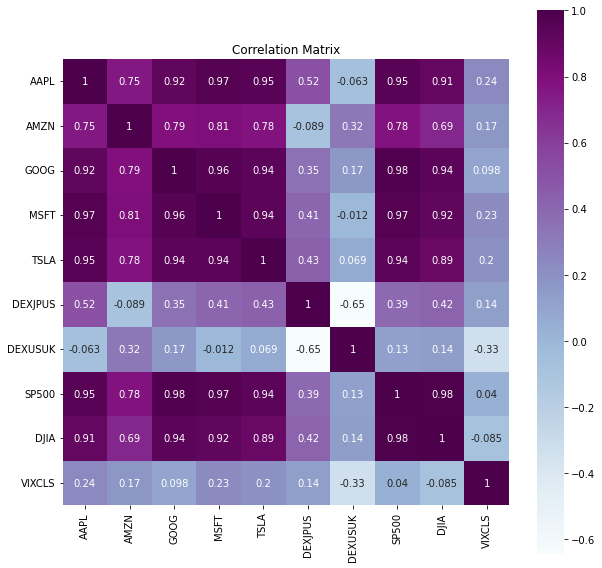

In [42]:
correlation = XData.corr()
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='BuPu')

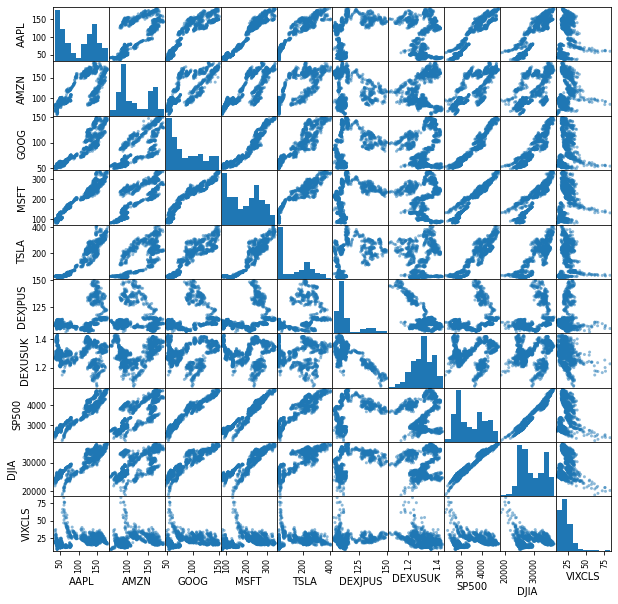

In [43]:
scatter_matrix(XData, figsize=(10,10))
plt.show()

#Data Prep

In [44]:
XData.isnull().sum()

AAPL        0
AMZN        0
GOOG        0
MSFT        0
TSLA        0
DEXJPUS    17
DEXUSUK    17
SP500       0
DJIA        0
VIXCLS      0
dtype: int64

In [45]:
'''XData.dropna(axis=0)    # deleting all rows with NaN values'''

'''XData = XData.fillna(0)  # In place of the NaN values we put 0'''

XData['DEXJPUS'] = XData['DEXJPUS'].fillna(XData['DEXJPUS'].mean())
XData['DEXUSUK'] = XData['DEXUSUK'].fillna(XData['DEXUSUK'].mean())

In [46]:
XData.isnull().sum()

AAPL       0
AMZN       0
GOOG       0
MSFT       0
TSLA       0
DEXJPUS    0
DEXUSUK    0
SP500      0
DJIA       0
VIXCLS     0
dtype: int64

#Data transaformation


In [47]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1))
rescaledX = pd.DataFrame(scaler.fit_transform(XData))
rescaledX.columns = XData.columns +'_res'
rescaledX.head()

,AAPL_res,AMZN_res,GOOG_res,MSFT_res,TSLA_res,DEXJPUS_res,DEXUSUK_res,SP500_res,DJIA_res,VIXCLS_res
0,0.045284,0.000000,0.043563,0.003406,0.023710,0.204228,0.797189,0.179125,0.342277,0.008431
1,0.045235,0.005975,0.052140,0.004856,0.023160,0.206342,0.776798,0.185866,0.347696,0.000000
2,0.046532,0.008095,0.054064,0.007610,0.022720,0.216913,0.781483,0.190137,0.356069,0.000952
3,0.049726,0.015784,0.061831,0.011524,0.023048,0.225370,0.787820,0.197623,0.368192,0.000952
4,0.048672,0.022758,0.064143,0.011850,0.026369,0.223256,0.788923,0.199405,0.367485,0.005031


#Standerdization

In [48]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(XData)
standerdisedX = pd.DataFrame(scaler.fit_transform(XData))
standerdisedX.columns = XData.columns + '_std'
standerdisedX.head()

,AAPL_std,AMZN_std,GOOG_std,MSFT_std,TSLA_std,DEXJPUS_std,DEXUSUK_std,SP500_std,DJIA_std,VIXCLS_std
0,-1.233199,-1.689191,-1.075326,-1.484584,-0.963246,-0.187751,0.891048,-1.164094,-1.084574,-1.385749
1,-1.233352,-1.667631,-1.046882,-1.479560,-0.965130,-0.178470,0.783172,-1.138153,-1.060197,-1.460410
2,-1.229279,-1.659981,-1.040503,-1.470015,-0.966641,-0.132066,0.807954,-1.121717,-1.022533,-1.451981
3,-1.219248,-1.632233,-1.014744,-1.456450,-0.965515,-0.094943,0.841483,-1.092905,-0.967998,-1.451981
4,-1.222558,-1.607067,-1.007080,-1.455320,-0.954124,-0.104224,0.847314,-1.086048,-0.971177,-1.415854


#Normaliztaion

In [49]:
from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(XData)
normalizedX = pd.DataFrame(scaler.fit_transform(XData))
normalizedX.columns = XData.columns + '_norm'
normalizedX.head()

,AAPL_norm,AMZN_norm,GOOG_norm,MSFT_norm,TSLA_norm,DEXJPUS_norm,DEXUSUK_norm,SP500_norm,DJIA_norm,VIXCLS_norm
0,0.001637,0.002381,0.002133,0.003233,0.000856,0.004492,0.000054,0.107960,0.994133,0.000391
1,0.001631,0.002402,0.002159,0.003235,0.000844,0.004479,0.000054,0.108217,0.994105,0.000365
2,0.001628,0.002398,0.002154,0.003244,0.000832,0.004471,0.000054,0.107995,0.994129,0.000366
3,0.001632,0.002415,0.002166,0.003256,0.000829,0.004448,0.000053,0.107808,0.994149,0.000362
4,0.001627,0.002451,0.002176,0.003261,0.000882,0.004446,0.000053,0.108040,0.994124,0.000374


#Evalluating ML Models

##Train Test splits

In [50]:
validationSize = 0.2    # % of data used for validation
seed = 1

X = X[:, np.newaxis]
Y = Y[:, np.newaxis]
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=validationSize, random_state=seed)

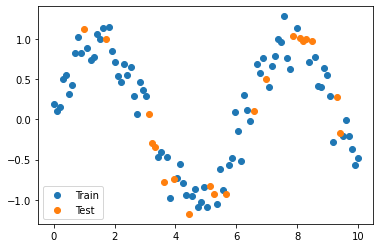

In [51]:
plt.scatter(XTrain, YTrain, label='Train')
plt.scatter(XTest, YTest, label='Test')
plt.legend(loc='best')
plt.show()

## Compare models & algos

In [52]:
# Linear regression Test
model = LinearRegression()
model.fit(XTrain, YTrain)
YPred = model.predict(XTrain)
rmseLin = np.sqrt(mean_squared_error(YTrain, YPred))
r2Lin = r2_score(YTrain,YPred)
print('RMSE for Linear Regression:', rmseLin)

# Polynomial Fit Test
polynomial_features = PolynomialFeatures(degree=2)
xPoly = polynomial_features.fit_transform(XTrain)

model = LinearRegression()
model.fit(xPoly, YTrain)
YPolyPred = model.predict(xPoly)
rsme = np.sqrt(mean_squared_error(YTrain, YPolyPred))
r2 = r2_score(YTrain, YPolyPred)
print('RMSE for Polynomial Regression:', rsme)

RMSE for Linear Regression: 0.6572271655463553
RMSE for Polynomial Regression: 0.6142884285992543


#Model tuning

Text(0.5, 0.98, 'Algo Comparison')

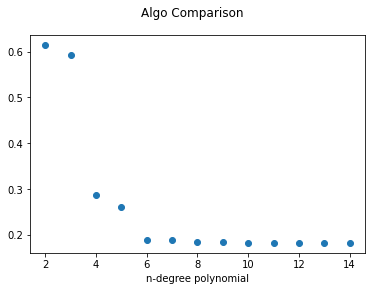

In [53]:
Deg = range(2,15)
results = []
names = []
for deg in Deg:
  polynomial_features = PolynomialFeatures(degree=deg)
  xPoly = polynomial_features.fit_transform(XTrain)
  model = LinearRegression()
  model.fit(xPoly, YTrain)
  YPolyPred = model.predict(xPoly)
  rmse = np.sqrt(mean_squared_error(YTrain, YPolyPred))
  r2 = r2_score(YTrain, YPolyPred)
  results.append(rmse)
  names.append(deg)
plt.plot(names, results, 'o')
plt.xlabel('n-degree polynomial')
plt.suptitle('Algo Comparison')

In [54]:
resDict = {name: res for name, res in zip(names, results)}
for name, res in resDict.items():
  print('deg: {0} RMSE: {1}'.format(name, res))

print('\nThe n-deg with min RSME:', min(resDict, key=resDict.get))

deg: 2 RMSE: 0.6142884285992543
deg: 3 RMSE: 0.5935761579564671
deg: 4 RMSE: 0.28743614410135615
deg: 5 RMSE: 0.2614562479577283
deg: 6 RMSE: 0.1877886639251576
deg: 7 RMSE: 0.1876529954697689
deg: 8 RMSE: 0.18470516170913126
deg: 9 RMSE: 0.18399807560943737
deg: 10 RMSE: 0.18267063045764614
deg: 11 RMSE: 0.18264097098705148
deg: 12 RMSE: 0.1823553256924693
deg: 13 RMSE: 0.1818354942201629
deg: 14 RMSE: 0.18218071082874132

The n-deg with min RSME: 13


#Finalizing the model

In [55]:
deg = 6
polynomial_features = PolynomialFeatures(degree=deg)
XPoly = polynomial_features.fit_transform(XTrain)
model = LinearRegression()
model.fit(XPoly, YTrain)
XPolyTest = polynomial_features.fit_transform(XTest)
YPolyPredTest = model.predict(XPolyTest)
rmse = np.sqrt(mean_squared_error(YTest,YPolyPredTest))
r2 = r2_score(YTest, YPolyPredTest)

print('deg: {0} RMSE: {1}'.format(deg, rmse))
print('deg: {0} R2: {1}'.format(deg, r2))

deg: 6 RMSE: 0.1674368928529666
deg: 6 R2: 0.9556542163596923


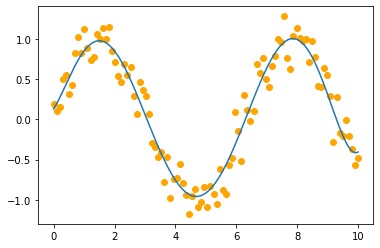

In [57]:
x = np.linspace(0,10,1000)
XPoly = polynomial_features.fit_transform(x[:, np.newaxis])
y = model.predict(XPoly)
plt.plot(x,y)
plt.scatter(X, Y, color='orange')

#Save/Load Model

In [58]:
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [59]:
loadedModel = load(open(filename, 'rb'))

In [65]:
XPolyTest = polynomial_features.fit_transform(XTest)
YPolyPredTest = loadedModel.predict(XPolyTest)
rmse = np.sqrt(mean_squared_error(YTest, YPolyPredTest))
r2 = r2_score(YTest, YPolyPredTest)

print('Deg: {0} RMSE: {1}'.format(deg, rmse))
print('Deg: {0} R2: {1}'.format(deg, r2))

Deg: 6 RMSE: 0.1674368928529666
Deg: 6 R2: 0.9556542163596923
